In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

style.use("fivethirtyeight")

# Source Causal Inference for the Braves and True
https://matheusfacure.github.io/python-causality-handbook/landing-page.html

## Key Ideas
1. We should add controls that are both correlated with the treatment and the outcome (confounder). 
2. We should also add controls that are good predictors of the outcome, even if they are not confounders, because they lower the variance of our estimates. 
3. However, we should NOT add controls that are just good predictors of the treatment, because they will increase the variance of our estimates.

Selection bias: always exclude variables that are mediators between the treatment and outcome or common effect of the treatment and outcome.

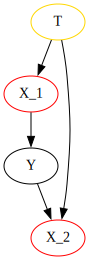

In [3]:
g = gr.Digraph()

g.edge("T", "X_1"), g.node("T", color="gold"), g.edge("X_1", "Y"), g.node("X_1", color="red")
g.edge("T", "X_2"), g.edge("Y", "X_2"), g.node("X_2", color="red")

g

In [2]:
data = pd.read_csv("./data/collections_email.csv")
data.head()

,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479
3,770,0,0.0,0.0,1531.828576,0.560488
4,660,0,0.0,0.0,979.855647,0.455140


The task is to estimate the impact of sending an email to people asking to renegotiate their debt.
This notebook helps to understand how critical is the choice of the covariates.

First since the data is random, the average treatment effect is simply the differences in mean.

In [5]:
ate = data.query("email==1")["payments"].mean() - data.query("email==0")["payments"].mean()
ate

-0.6202804021329484

This is weird sending an email makes people pay less on average.

In [13]:
model = smf.ols("payments ~ email", data=data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,669.9764,2.061,325.116,0.000,665.937,674.016
email,-0.6203,2.941,-0.211,0.833,-6.387,5.146


The P-value is so high that ate probably does not mean anything.

In linear regression a variable is a good predictor of the outcome if it can explain a lot of its variance.

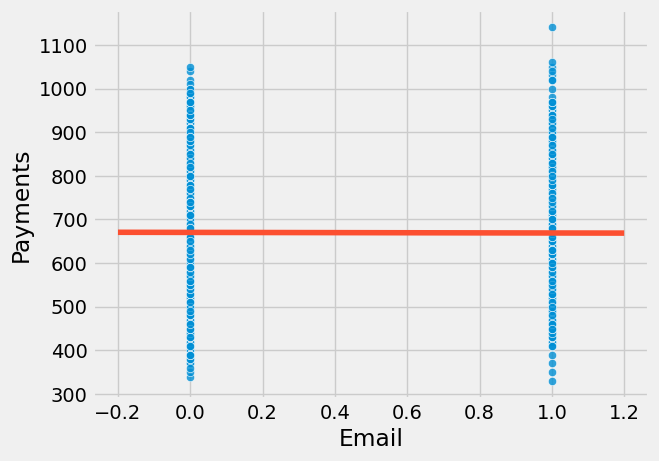

In [18]:
sns.scatterplot(data=data, x='email', y='payments',
                alpha=0.8,
                )
plt.plot(np.linspace(-0.2, 1.2), model.params[0] + np.linspace(-1, 2) * model.params[1], c="C1")
plt.xlabel("Email")
plt.ylabel("Payments");

Payments vary widly in a single treatment group. We can add more variables like risk and credit to find the impact of the email of the payments. In other words, if risk and credit line predict payments very well, customers with similar risk and credit line should also have similar payments, hence less variance.

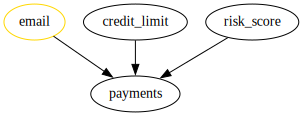

In [5]:
g = gr.Digraph()

g.node("email", color="gold")
g.edge("credit_limit", "payments")
g.edge("risk_score", "payments")
g.edge("email", "payments")

g

In [20]:
model_2 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


This new estimate tells us that on average customers, that received the email, pay 4.4 rmore than those in the control group. This estimate is now statistically different from zero.

# More (variables) is not always the better

A drug test scenario with 2 hospitals:
- Both of them are conducting randomised trials on a new drug to treat a certain illness. The outcome of interest is days hospitalised. If the treatment is effective, it will lower the amount of days the patient stays in the hospital. 
- For one of the hospitals, the policy regarding the random treatment is to give it to 90% of its patients while 10% get a placebo. 
- The other hospital has a different policy: it gives the drug to a random 10% of its patients and 90% get a placebo. 
You are also told that the hospital that gives 90% of the true drug and 10% of placebo usually gets more severe cases of the illness to treat. 

In [21]:
hospital = pd.read_csv("./data/hospital_treatment.csv")
hospital.head()

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


In [22]:
hosp_1 = smf.ols('days ~ treatment', data=hospital).fit()
hosp_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,33.2667,2.662,12.498,0.000,27.968,38.566
treatment,14.1533,3.367,4.204,0.000,7.451,20.856


In [23]:
hosp_2 = smf.ols('days ~ treatment + severity', data=hospital).fit()
hosp_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.6641,2.000,5.832,0.000,7.681,15.647
treatment,-7.5912,2.269,-3.345,0.001,-12.110,-3.073
severity,2.2741,0.154,14.793,0.000,1.968,2.580


Should we include hospitals in the model?

In [24]:
hosp_3 = smf.ols('days ~ treatment + severity + hospital', data=hospital).fit()
hosp_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.0111,2.118,5.198,0.000,6.792,15.230
treatment,-5.0945,3.492,-1.459,0.149,-12.049,1.861
severity,2.3865,0.195,12.251,0.000,1.999,2.774
hospital,-4.1535,4.413,-0.941,0.350,-12.943,4.636


Introducing hospitals as control introduced MORE variance to the ATE estimator (treatment)

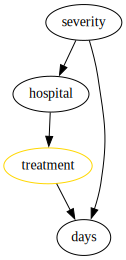

In [6]:
g = gr.Digraph()


g.node("treatment", color="gold")
g.edge("severity", "hospital")
g.edge("severity", "days")
g.edge("hospital", "treatment")
g.edge("treatment", "days")

g